<img src="assets/cyberbully2.jpg"> 


# Toxic Comments Classification Challenge

### Big Data and Brews

**July 7, 2018**


In this social media era, many businesses are moving to incorporate user interaction and discussion in their platforms. However, a minority of users use the technology inappropriately, using it to threaten, insult, or create a generally toxic atmosphere. 

We work to classify these toxic comments, without censoring the population as a whole. 

We investigate ~160,000 comments, about **89.8%** are normal user interaction, and **10.2%** are toxic. The comments are classified in the following 6 ways: 
 * Toxic
 * Severely toxic
 * Obscene
 * Insult
 * Threat
 * Identity hate

Many toxic comments are classified with more than one label. The labels have been classified by human raters. 

A link to the challenge can be found here: 
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data


In [1]:
import re 
import pandas as pd
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# This needs to be run one time only
#nltk.download('wordnet')

## Data Exploration

In [228]:
train = pd.read_csv('./files/train.csv')
test = pd.read_csv('./files/test.csv')
test_labels = pd.read_csv('./files/test_labels.csv')

In [229]:
train = train.loc[:100000, :]

### A selection of 'nasty' comments:


In [230]:
# Print the first 20 comments matching the description
for comment in train[train['insult'] == 1]['comment_text'].index[:1]:
    print("\n\nNext:\n")
    print(train.loc[comment]['comment_text'])
    print(train.loc[comment][:])



Next:

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
id                                           0002bcb3da6cb337
comment_text     COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
toxic                                                       1
severe_toxic                                                1
obscene                                                     1
threat                                                      0
insult                                                      1
identity_hate                                               0
Name: 6, dtype: object


### A selection of non-offensive comments: 

In [231]:
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[cols].max(axis = 1)

In [232]:
for comment in train[train['none'] == 1]['comment_text'].index[:1]:
    print("\n\nNext:\n")
    print(train.loc[comment]['comment_text'])
    print(train.loc[comment][:])



Next:

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
id                                                0000997932d777bf
comment_text     Explanation\nWhy the edits made under my usern...
toxic                                                            0
severe_toxic                                                     0
obscene                                                          0
threat                                                           0
insult                                                           0
identity_hate                                                    0
none                                                             1
Name: 0, dtype: object


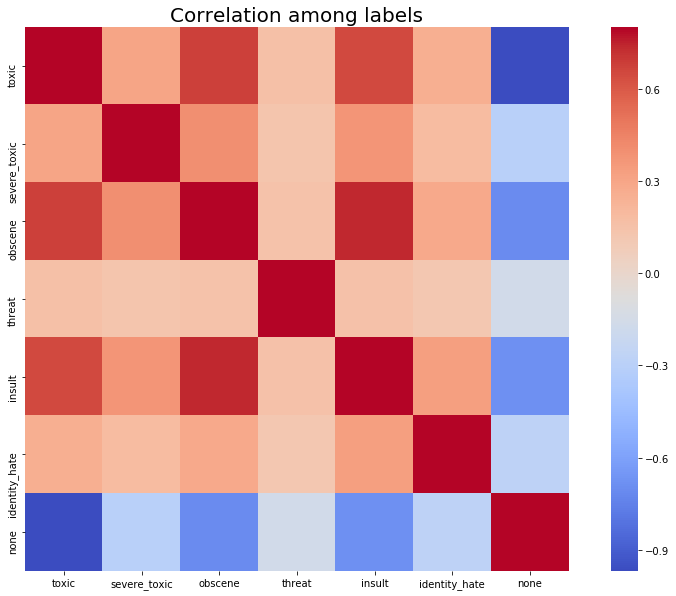

In [233]:
train.iloc[: ,2:].corr()

# Correlation matrix of labels
corrmat = train.iloc[: ,2:].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax = .8, square = True, cmap = 'coolwarm')
plt.title("Correlation among labels", size = 20)

plt.show()

In [234]:
print('Number of labels in each category:')
print(train.iloc[: ,2:].sum())
print('\nNumber of total training comments:')
print(len(train))

Number of labels in each category:
toxic             9612
severe_toxic       999
obscene           5327
threat             314
insult            4967
identity_hate      854
none             89810
dtype: int64

Number of total training comments:
100001


## Data Cleaning

### Class imbalance issues:

We see that some labels are very rare in the training set.  

In [235]:
label_cols = train.iloc[: ,2:]
print("Relative abundance of labels within the training set:\n")
for col in label_cols:
    info = '{} :\t {}%\t({} total)'.format(
        col, 
        "%.1f" %( train[col].sum()/train.shape[0]*100), train[col].sum()) 
    print(info)

Relative abundance of labels within the training set:

toxic :	 9.6%	(9612 total)
severe_toxic :	 1.0%	(999 total)
obscene :	 5.3%	(5327 total)
threat :	 0.3%	(314 total)
insult :	 5.0%	(4967 total)
identity_hate :	 0.9%	(854 total)
none :	 89.8%	(89810 total)


In [236]:
# Balance each category by under-sampling the majority class  
def undersample(train, col):
    smallSampleClean = train[train[col] == 0].sample(3*train[col].sum())[['comment_text', col]]
    smallSampleDirty = train[train[col] == 1][['comment_text', col]]
    frames = [smallSampleClean, smallSampleDirty]
    newTrain = pd.concat(frames, axis = 0)
    newTrain.shape
   
    return newTrain


def test_undersample(train, col):
    print("Dimensions before undersampling for ", col, ": ", train.shape)
    newTrain = undersample(train, col)
    print("Dimensions after undersampling for ", col, ": ", newTrain.shape)
    
    if newTrain.shape[0] == 2*len(train[train[col] ==1 ]) and newTrain.shape[1] == 2:
        print("test passed")
    else: print("Error occurred in test_undersample")
test_undersample(train, 'threat') 


Dimensions before undersampling for  threat :  (100001, 9)
Dimensions after undersampling for  threat :  (1256, 2)
Error occurred in test_undersample


In [237]:
# Create a dictionary of the labels and their respective 

threat = undersample(train, 'threat')
toxic = undersample(train, 'toxic')
severe_toxic = undersample(train, 'severe_toxic')
obscene = undersample(train, 'obscene')
insult = undersample(train, 'insult')
identity_hate = undersample(train, 'identity_hate')

testSets = {'threat': threat,
           'toxic': toxic,
           'severe_toxic': severe_toxic,
            'obscene': obscene,
            'insult': insult,
            'identity_hate': identity_hate
           }


In [238]:
print("Undersampled abundance of labels within the training set:\n")
for test in testSets:    
    info = '{} : {}%\t({} total)'.format(
        test, "%.1f" %( 100*(testSets[test][test].sum())/len(testSets[test]))
                 , testSets[test][test].sum()) 
    print(info)

Undersampled abundance of labels within the training set:

threat : 25.0%	(314 total)
toxic : 25.0%	(9612 total)
severe_toxic : 25.0%	(999 total)
obscene : 25.0%	(5327 total)
insult : 25.0%	(4967 total)
identity_hate : 25.0%	(854 total)


We now have a dictionary of balanced datasets, which has reduced the size of the training dataset by undersampling the majority class. 

## Clean the comment field

*Step 1: Remove numbers and bad characters. We feed the dataframe into the text_prepare method, which cleans out IP addresses, bad characters, and sets all words to lower case.* 

*For later improvement, it might be good to find and remove proper nouns from the training set. Because these comments come from Wikipedia pages where users are discussing a large range of topics, removing many of the proper nouns might help hone in on other words that may be more informative.*

*Including proper nouns may also cause overfitting to particular topics where many of the toxic comments are originating*

In [239]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|\\@,;]')
BAD_SYMBOLS_RE = re.compile('[^a-z #+_]') 

def text_prepare(text):
    text = text.lower()
    for ch in text:
        if REPLACE_BY_SPACE_RE.match(ch):
            text = text.replace(ch, " ")
        if BAD_SYMBOLS_RE.match(ch):
            text = text.replace(ch, '')
    return text

def test_text_prepare():
    examples = ['SQL Server -887.97equivalent']
    answers = ['sql server equivalent']
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            print(text_prepare(ex))
            return "Something's not quite right"
            
    return "Basic tests are passed"

print(test_text_prepare())

Basic tests are passed


In [240]:
# Normalize and clean the comment field by bringing all to lower case, 
# removing IP addresses and other numerical fields, 
# and removing other non-letter characters. 

# also tokenize and (stem or lemmatize)
%timeit
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = nltk.tokenize.TreebankWordTokenizer()
#stemmer = nltk.stem.PorterStemmer()
stemmer = nltk.stem.WordNetLemmatizer()


for test in testSets:
    currentDF = testSets[test]
    for comment in (currentDF.comment_text):
        #Clean comments
        #print("Before comment: ", comment)        
        commentCleaned = text_prepare(comment)

        # We break up each comment into word tokens, then 
        # take the lemma (dictionary root word) or stem (base word) of that token. 
        tokens = tokenizer.tokenize(commentCleaned)
        commentCleaned = " ".join(stemmer.lemmatize(token) for token in tokens)
        #print("After comment: ", comment, '\n\n')
        
        currentDF.loc[currentDF['comment_text'] == comment , 'comment_text'] = commentCleaned
    testSets[test].update(currentDF)
    

## Create Sparse and Dense Datasets

In [241]:
from sklearn.feature_extraction.text import TfidfVectorizer

features = {}
sparseData = {}
# testSets is the dictionary containing each model set
# test is 'threat', 'insult', etc and correlated data
for test in testSets:
    # features are the tfidf outputs for each model data set
    tfidf = TfidfVectorizer(stop_words='english', min_df=0.005, max_df=0.40, ngram_range=(1,3))
    features[test] = tfidf.fit_transform(testSets[test]['comment_text'])
    # sparseData is the sparse dataframe output
    sparseData[test] = pd.DataFrame(features[test].todense(), columns = tfidf.get_feature_names())
    

## Logistic Regression

In [242]:
from sklearn import linear_model

In [243]:
regr = linear_model.LogisticRegression()
X = sparseData['insult']
y = testSets['insult']['insult']
#pred = regr.fit(sparseData, train[toxic])

In [244]:
fitted = regr.fit(X, y)

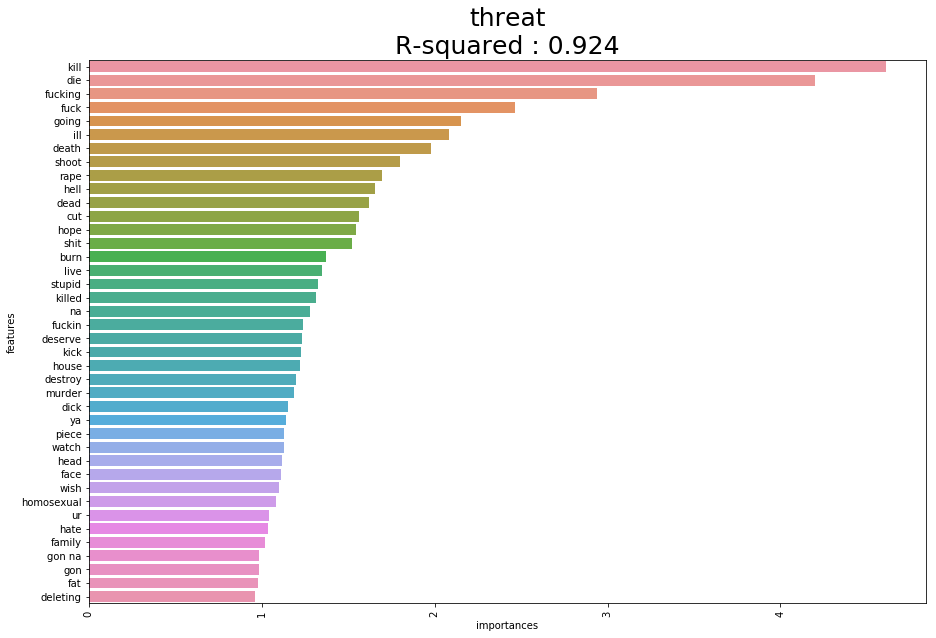

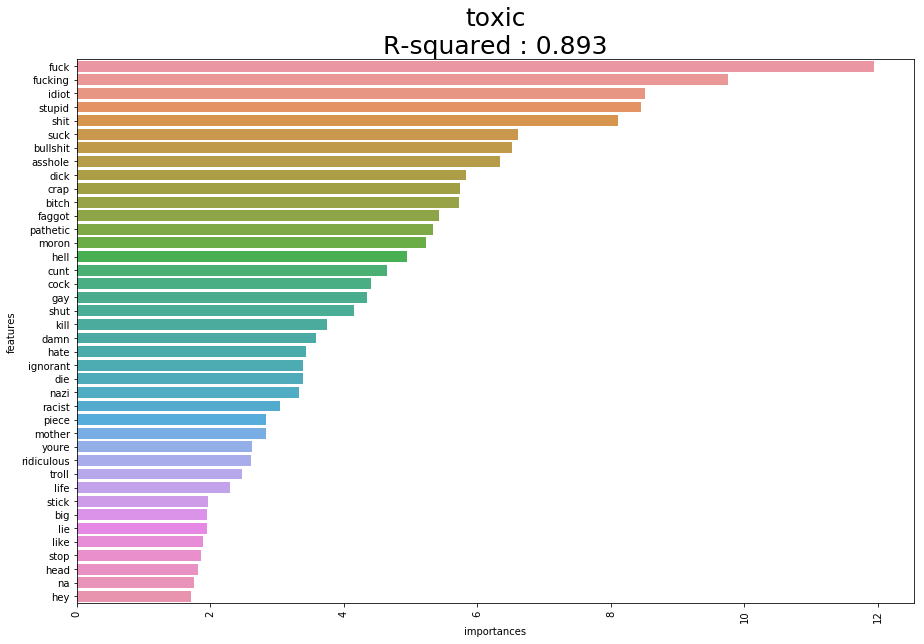

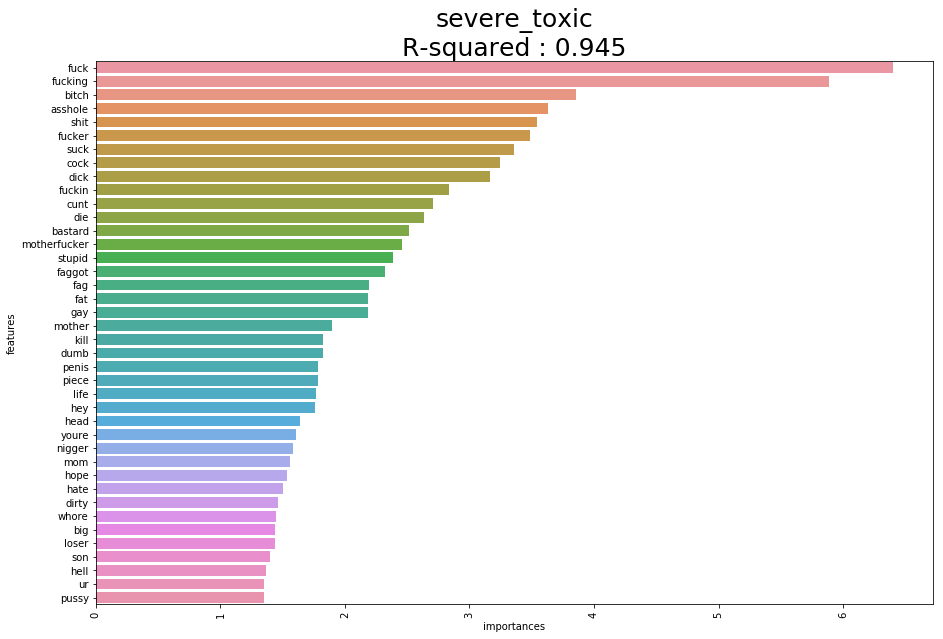

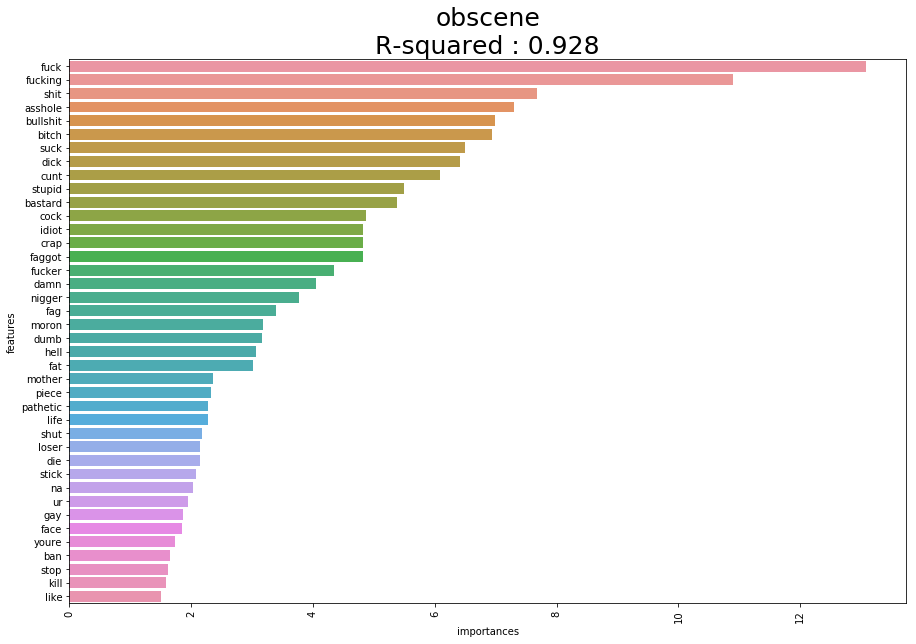

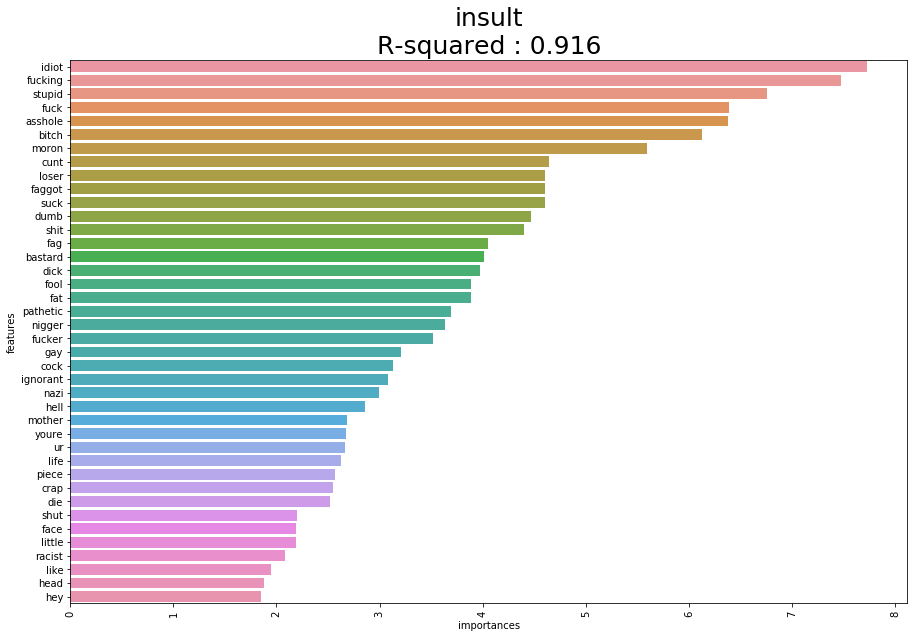

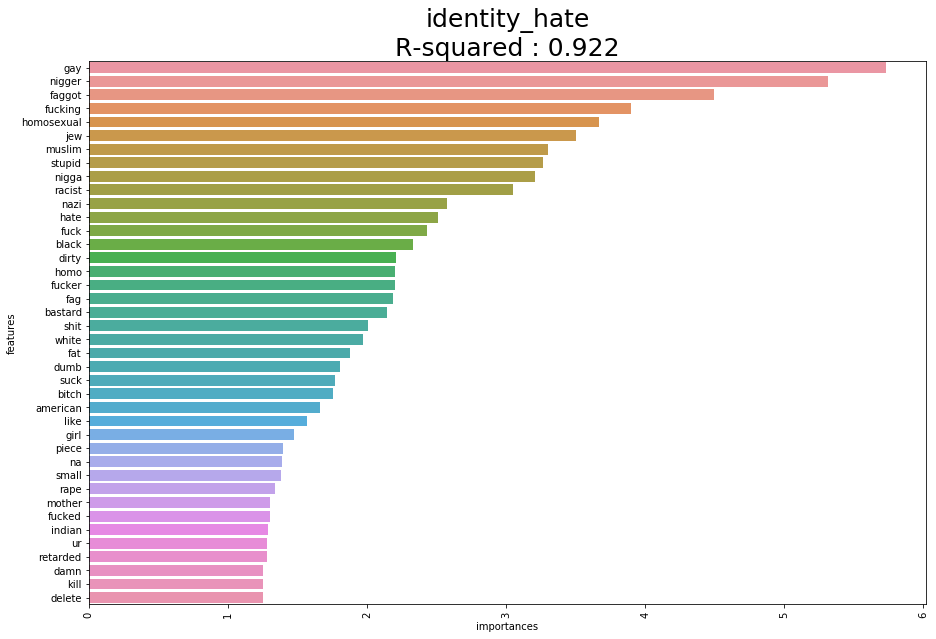

In [245]:
#preds = pd.DataFrame()
for test in testSets: 
    X = sparseData[test]
    y = testSets[test][test]
    fitted = regr.fit(X, y)
    
    features = list(X.columns)
    importances = list(fitted.coef_)
    index = range(len(X.columns))

    best_features = pd.DataFrame({'features': features, 'importances': importances[0]})
    best_features.sort_values(by=['importances'], ascending = False, inplace=True)

    bestPredictors = best_features[:40]

    plt.figure(figsize = (15,10))
    sns.barplot(bestPredictors["importances"], bestPredictors["features"])
    plt.title(str(test) + "\nR-squared : " +  str("%.3f" %fitted.score(X,y)), size = 25)
    
    plt.xticks(rotation = 90)
    

In [246]:
from sklearn.model_selection import cross_val_score

regr = linear_model.LogisticRegression()

for test in testSets: 
    X = sparseData[test]
    y = testSets[test][test]
    print("\n\nCol:", test)
    regr_score = cross_val_score(regr, X, y, cv=10)
    print("Cross-Validated R-Squared of Linear Regression Model: %0.2f (+/- %0.2f)" 
          % (regr_score.mean(), regr_score.std() * 2))



Col: threat
Cross-Validated R-Squared of Linear Regression Model: 0.90 (+/- 0.05)


Col: toxic
Cross-Validated R-Squared of Linear Regression Model: 0.89 (+/- 0.01)


Col: severe_toxic
Cross-Validated R-Squared of Linear Regression Model: 0.93 (+/- 0.02)


Col: obscene
Cross-Validated R-Squared of Linear Regression Model: 0.92 (+/- 0.01)


Col: insult
Cross-Validated R-Squared of Linear Regression Model: 0.91 (+/- 0.01)


Col: identity_hate
Cross-Validated R-Squared of Linear Regression Model: 0.90 (+/- 0.03)


## Naive Bayes Classification


### In progress....

In [247]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()


for test in testSets:
    #X = sparseData[test]
    X = sparseData[test]
    y = testSets[test][test]
    # Fit our model to the data.
    bnb.fit(X, y)

    # Classify, storing the result in a new variable.   
    print("\n\nCol:", test)
    bnb_score = cross_val_score(bnb, X, y, cv=10)
    print("Cross-Validated R-Squared of Linear Regression Model: %0.2f (+/- %0.2f)" 
          % (bnb_score.mean(), bnb_score.std() * 2))
    



Col: threat
Cross-Validated R-Squared of Linear Regression Model: 0.80 (+/- 0.07)


Col: toxic
Cross-Validated R-Squared of Linear Regression Model: 0.70 (+/- 0.02)


Col: severe_toxic
Cross-Validated R-Squared of Linear Regression Model: 0.78 (+/- 0.03)


Col: obscene
Cross-Validated R-Squared of Linear Regression Model: 0.73 (+/- 0.02)


Col: insult
Cross-Validated R-Squared of Linear Regression Model: 0.72 (+/- 0.02)


Col: identity_hate
Cross-Validated R-Squared of Linear Regression Model: 0.76 (+/- 0.06)


## Strategic Approaches:

[ X ] **Tokenize with 1-grams, 2-grams, 3-grams**

[ X ] **Tokenize on stop words**

[ X ] **Tokenize after casting all to lowercase**


[ X ] **Approach 1:** Use TFIDF (Term Frequency * Inverse Doc Frequency on the Words in the Corpus. Use Logistic Regression, Naive Bayes. 

[   ] Incorporate word2vec, max pooling in a convolutional layer

[   ] **Approach 2:** Use neural network at word level. 

[   ] **Approach 3:** Use neural network on character level. 


[   ] **Compare results. **